In [1]:
# %%
# Mask-based Curve Detection Model - PyTorch Implementation with Matching, Dice+Focal Loss, Attention Head
# Updated by ChatGPT - May 2025

import os
import json
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import linear_sum_assignment

# =========================
# 1. Dataset
# =========================

class MaskDataset(Dataset):
    def __init__(self, data_dir, max_lines=3):
        self.data_dir = data_dir
        self.samples = [f for f in os.listdir(data_dir) if f.endswith(".json")]
        self.max_lines = max_lines

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        json_path = os.path.join(self.data_dir, self.samples[idx])
        with open(json_path, 'r') as f:
            sample = json.load(f)

        matrix = np.array(sample['data'], dtype=np.float32)
        matrix = torch.tensor(matrix).unsqueeze(0)

        masks = []
        types = []

        for m in sample['masks']:
            types.append(m['type'])
            mask_array = np.array(m['mask'], dtype=np.uint8)
            masks.append(mask_array)

        while len(masks) < self.max_lines:
            masks.append(np.zeros_like(matrix.squeeze(0)))
            types.append(-1)

        masks = np.stack(masks[:self.max_lines])
        types = np.array(types[:self.max_lines])

        return matrix, torch.tensor(masks, dtype=torch.float32), torch.tensor(types, dtype=torch.long)


# =========================
# 2. Hungarian Matcher
# =========================
class HungarianMatcher:
    def __init__(self):
        pass

    def match(self, pred_masks, gt_masks):
        B, N, H, W = pred_masks.shape
        indices = []
        for b in range(B):
            cost_matrix = torch.cdist(pred_masks[b].flatten(1), gt_masks[b].flatten(1), p=1).cpu().numpy()
            row_ind, col_ind = linear_sum_assignment(cost_matrix)
            indices.append((row_ind, col_ind))
        return indices


# =========================
# 3. Loss Functions
# =========================

def dice_loss(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    inter = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    dice = (2 * inter + smooth) / (union + smooth)
    return 1 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return loss.mean()


def mask_loss(pred_masks, pred_types, gt_masks, gt_types, matcher):
    dice = dice_loss(pred_masks, gt_masks)
    focal = FocalLoss()(pred_masks, gt_masks)

    B, N, C = pred_types.shape
    pred_types = pred_types.view(B * N, C)
    gt_types = gt_types.view(B * N)
    ce = nn.CrossEntropyLoss(ignore_index=-1)
    type_loss = ce(pred_types, gt_types)

    return dice + focal + type_loss


# =========================
# 4. Model with Attention Head
# =========================

class AttentionTypeHead(nn.Module):
    def __init__(self, embed_dim, max_lines, num_types):
        super().__init__()
        self.query = nn.Parameter(torch.randn(max_lines, embed_dim))
        self.fc = nn.Linear(embed_dim, num_types)

    def forward(self, features):
        B, C, H, W = features.shape
        feats = features.view(B, C, -1)
        attn = torch.einsum('ln, bcn -> blc', self.query, feats) / (C ** 0.5)
        attn = torch.softmax(attn, dim=-1)
        pooled = torch.einsum('blc, bcn -> bln', attn, feats.transpose(1, 2))
        out = self.fc(pooled)
        return out

class MaskTypeTransformer(nn.Module):
    def __init__(self, num_types=3, max_lines=3):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.ReLU(),
            # nn.Conv2d(64, 128, 3, 1, 1),
            # nn.ReLU(),
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.ReLU()
        )  # 输出 [B, 256, H, W]

        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=4, dim_feedforward=512)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.mask_head = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(128, max_lines, 1)  # [B, max_lines, H, W]
        )
        self.type_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),  # [B, 256]
            nn.Linear(256, max_lines * num_types),
        )
        self.num_types = num_types
        self.max_lines = max_lines

    def forward(self, x):  # [B, 1, H, W]
        feats = self.backbone(x)  # [B, 256, H, W]
        B, C, H, W = feats.shape

        x_flat = feats.flatten(2).permute(2, 0, 1)  # [HW, B, C]
        encoded = self.transformer(x_flat)  # [HW, B, C]
        encoded = encoded.permute(1, 2, 0).view(B, C, H, W)  # [B, C, H, W]

        masks = self.mask_head(encoded)  # [B, max_lines, H, W]
        types = self.type_head(encoded).view(B, self.max_lines, self.num_types)  # [B, max_lines, num_types]

        return masks, types

# =========================
# 5. Train Function
# =========================

def train(model, loader, optimizer, device, matcher):
    model.train()
    total_loss = 0
    for x, y_masks, y_types in loader:
        x = x.to(device)
        y_masks = y_masks.to(device)
        y_types = y_types.to(device)

        pred_masks, pred_types = model(x)
        loss = mask_loss(pred_masks, pred_types, y_masks, y_types, matcher)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)


# =========================
# 6. Visualization
# =========================

def visualize_masks(matrix, pred_masks, threshold=0.5):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.imshow(matrix.squeeze().cpu(), cmap='gray', aspect='auto')
    pred_masks = torch.sigmoid(pred_masks)
    for i in range(pred_masks.shape[0]):
        mask = pred_masks[i] > threshold
        if mask.sum() > 0:
            ax.contour(mask.cpu().numpy(), levels=[0.5], colors=[f"C{i}"])
    ax.set_title("Predicted Masks")
    plt.show()


In [2]:
# =========================
# 7. Run Example
# =========================

data_dir = "datasets_json"
dataset = MaskDataset(data_dir)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

model = MaskTypeTransformer().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
matcher = HungarianMatcher()


history_loss = []
checkpoint_path = "checkpoint.pth"
start_epoch = 0     # 尝试恢复
# if os.path.exists(checkpoint_path):
#     checkpoint = torch.load(checkpoint_path)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     start_epoch = checkpoint['epoch'] + 1
#     history_loss = checkpoint.get('history_loss', [])
#     print(f"恢复训练：从 epoch {start_epoch} 开始")
# else:
#     print("从头开始训练")

# 开始训练
for epoch in range(start_epoch, 200):  # 假设训练 50 个 epoch
    loss = train(model, loader, optimizer, device="cuda", matcher=matcher)
    print(f"Epoch {epoch}: Loss = {loss:.4f}")
    history_loss.append([epoch, loss])
    if epoch % 20 == 0:
        # 保存 checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history_loss': history_loss
        }, checkpoint_path)

history_loss = np.array(history_loss)


/csim2/zhangzhiyu/miniconda3/envs/ccfj/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0: Loss = 1.0476
Epoch 20: Loss = 0.9938
Epoch 40: Loss = 0.9726
Epoch 60: Loss = 0.9977
Epoch 80: Loss = 0.9452
Epoch 100: Loss = 0.9977
Epoch 120: Loss = 0.9977
Epoch 140: Loss = 0.9977
Epoch 160: Loss = 0.9978
Epoch 180: Loss = 0.9977


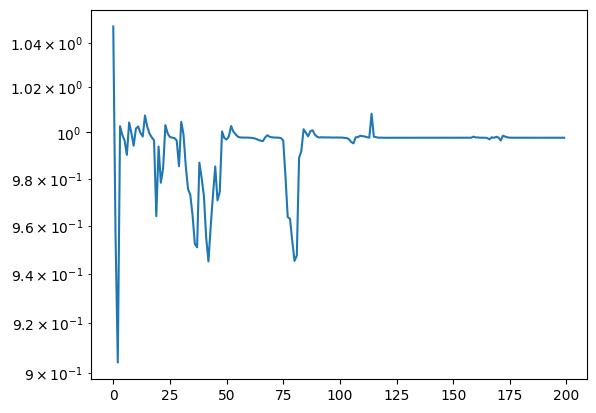

In [3]:
plt.plot(history_loss[:, 0], history_loss[:, 1])
plt.yscale('log')
plt.show()

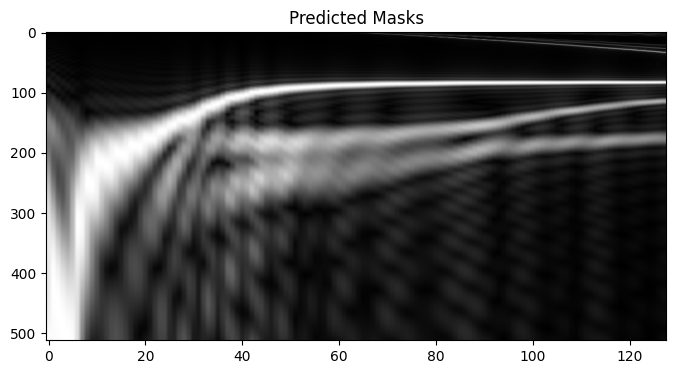

In [4]:
x, y_masks, y_types = next(iter(loader))
i = 0
model.eval()
with torch.no_grad():
    pred_masks, pred_types = model(x.cuda())
visualize_masks(x[i], pred_masks[i])

In [5]:
pred_masks[0].shape

torch.Size([3, 512, 128])

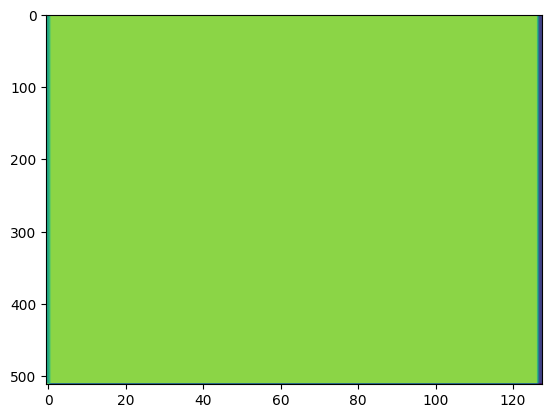

In [10]:
plt.imshow(pred_masks[1][2].cpu(),aspect='auto')